In [18]:
from src.base import FDTD2D
from src.utilis import *

### Setting the simulation parameters from a dictionary

In [8]:
# Parameters
params = {
    'nx': 200,
    'ny': 200,
    'time_steps': 250,
    'dx':25e-9,
    'dy': 25e-9,
    # PML
    'use_pml' : True,
    'pml_thickness': 20,
    'polarization': 'TM',
    # TFSF
    'tfsf_thickness': 10,
    'order': 1,
    'r_err': 1e-6,
    # source
    'source_type': 'plane_wave',
    'form_type': 'gaussian',
    'plane_x1' : 7,
    'plane_x2' :193,
    'plane_y1' : 7,
    'plane_y2' : 193
}

### Testing initializations

In [20]:
#tm_sim = FDTD2D(params = params)
tm_sim = FDTD2D(config_file = 'config.yaml')

print(f"\n{tm_sim.polarization} Polarization:")
print(f"Hx grid shape: {tm_sim.Hx.shape}")
print(f"Hy grid shape: {tm_sim.Hy.shape}")
print(f"Ez grid shape: {tm_sim.Ez.shape}")
print(f"Dz grid shape: {tm_sim.Dz.shape}")
print(f"Number of time step: {tm_sim.time_steps}")
print(f"Source type: {tm_sim.source_type}")
print(f"dt: {tm_sim.dt}, dx: {tm_sim.dx}, dy: {tm_sim.dy}")
#print(f"Frequency: {tm_sim.frequency}")

Reading configuration from file...

TM Polarization:
Hx grid shape: torch.Size([200, 200])
Hy grid shape: torch.Size([200, 200])
Ez grid shape: torch.Size([200, 200])
Dz grid shape: torch.Size([200, 200])
Number of time step: 100
Source type: point_source
dt: 1.6666666666666669e-18, dx: 1e-09, dy: 1e-09


### Testing define geometry

In [21]:
tm_sim.gaz, tm_sim.gbz = circle_primitive(tm_sim.nx,tm_sim.ny,80,80,5,30,8.854e-12,0.3,tm_sim.gaz,tm_sim.gbz,tm_sim.dt)

In [4]:
tm_sim.gaz, tm_sim.gbz =rectangle_primitive(tm_sim.nx,tm_sim.ny,95,105,0,200,12,8.854e-12,0.3,tm_sim.gaz,tm_sim.gbz,tm_sim.dt)

c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Show material distribution

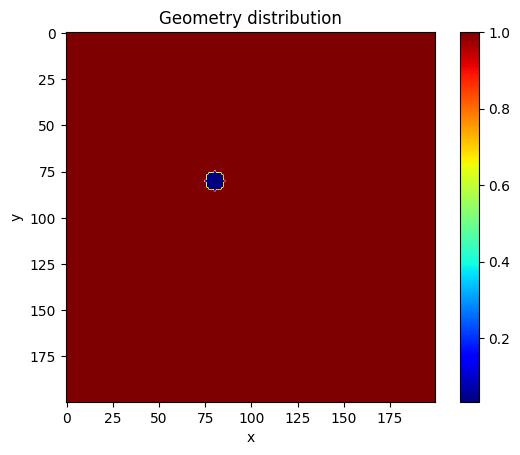

In [22]:
# Visualize permittivity distribution
from matplotlib import pyplot as plt
plt.imshow(tm_sim.gaz, cmap='jet')
plt.title('Geometry distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(cmap='jet')
plt.show()

### Test simulation

In [23]:
for i in range(1, tm_sim.time_steps):
    tm_sim.simulation_step(i)

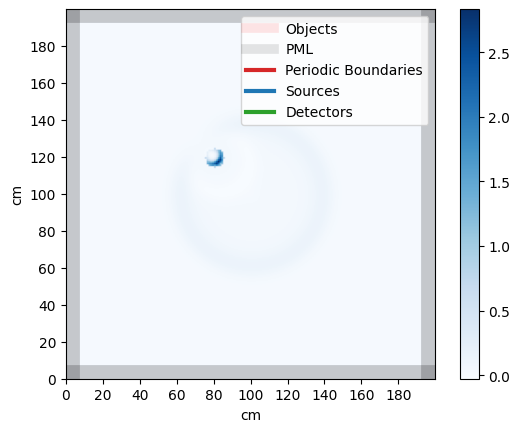

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the energy distribution
#tm_sim = lambda: None  # Dummy object to simulate your data
#tm_sim.Dz = np.random.rand(100, 100)  # Replace with your actual energy data
tm_sim.nx, tm_sim.ny = tm_sim.Dz.shape

# Properties of the energy sources, geometry, and PML layers
source_positions = [(10, 10), (90, 90)]  # Replace with actual source positions
detector_positions = [(90, 10), (10, 90)]  # Replace with actual detector positions
pml_thickness = tm_sim.pml_thickness

# Colors and plot settings
cmap = "Blues"
geom_cmap = "jet"
pbcolor = "C3"
pmlcolor = (0, 0, 0, 0.1)
objcolor = (1, 0, 0, 0.1)
srccolor = "C0"
detcolor = "C2"

# Create the right legend entries
fig, ax = plt.subplots()
plt.plot([], lw=7, color=objcolor, label="Objects")
plt.plot([], lw=7, color=pmlcolor, label="PML")
plt.plot([], lw=3, color=pbcolor, label="Periodic Boundaries")
plt.plot([], lw=3, color=srccolor, label="Sources")
plt.plot([], lw=3, color=detcolor, label="Detectors")

# Display the geometry
plt.imshow(tm_sim.gaz, cmap=geom_cmap, extent=[0, tm_sim.nx, 0, tm_sim.ny], alpha=1.0)

# Display the energy distribution
plt.imshow(tm_sim.Dz, cmap=cmap, extent=[0, tm_sim.nx, 0, tm_sim.ny], alpha=1.0)

# Draw PML layers
for edge in [0, tm_sim.nx, 0, tm_sim.ny]:
    plt.axhline(edge, lw=pml_thickness, color=pmlcolor)
    plt.axvline(edge, lw=pml_thickness, color=pmlcolor)

# Draw sources
##for src_x, src_y in source_positions:
##    plt.plot(src_x, src_y, 'o', color=srccolor)

# Draw detectors
##for det_x, det_y in detector_positions:
##   plt.plot(det_x, det_y, 'x', color=detcolor)

# Configure axis and colorbar
ax.set_xticks(np.arange(0, tm_sim.nx, step=20))
ax.set_yticks(np.arange(0, tm_sim.ny, step=20))
plt.colorbar(cmap='jet')
plt.xlabel('cm')
plt.ylabel('cm')

# Display the legend and show the plot
plt.legend()
plt.show()


In [54]:
!pip install vtk

     ---------------------------------------- 49.2/49.2 MB 2.8 MB/s eta 0:00:00


In [25]:
import numpy as np
import vtk
from vtk.util import numpy_support

tm_sim.nx, tm_sim.ny = tm_sim.Dz.shape

# Convert the numpy arrays to vtkImageData
energy_data = numpy_support.numpy_to_vtk(tm_sim.Dz.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
geometry_data = numpy_support.numpy_to_vtk(tm_sim.gaz.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

energy_image = vtk.vtkImageData()
energy_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
energy_image.GetPointData().SetScalars(energy_data)

# geometry_image = vtk.vtkImageData()
# geometry_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
# geometry_image.GetPointData().SetScalars(geometry_data)

# Create actors for energy and geometry data
energy_mapper = vtk.vtkDataSetMapper()
energy_mapper.SetInputData(energy_image)
energy_actor = vtk.vtkActor()
energy_actor.SetMapper(energy_mapper)

# geometry_mapper = vtk.vtkDataSetMapper()
# geometry_mapper.SetInputData(geometry_image)
# geometry_actor = vtk.vtkActor()
# geometry_actor.SetMapper(geometry_mapper)

# Set up the renderer and render window
renderer = vtk.vtkRenderer()
renderer.AddActor(energy_actor)
# renderer.AddActor(geometry_actor)
renderer.SetBackground(0.2, 0.2, 0.2)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 800)

# Set up the interactor and start the visualization
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)
interactor.Initialize()
interactor.Start()